<a href="https://colab.research.google.com/github/Skp80/002_MachineLearning_eBook/blob/master/CS_329S_Monitoring_%26_Observability_for_real_world_ML_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **ML Telemetry: whylogs profiling in action** 
# **ML Observability: self-onboard & fiddle w/ the WhyLabs Observatory platform**

### 🛠 **ML Telemetry: Install whylogs and import dependencies** 
To begin, uncomment the cell below and install the **[whylogs](https://github.com/whylabs/whylogs)** library.

[![License](http://img.shields.io/:license-Apache%202-blue.svg)](https://github.com/whylabs/whylogs-python/blob/mainline/LICENSE)
[![PyPI version](https://badge.fury.io/py/whylogs.svg)](https://badge.fury.io/py/whylogs)
[![Coverage Status](https://coveralls.io/repos/github/whylabs/whylogs/badge.svg?branch=mainline)](https://coveralls.io/github/whylabs/whylogs?branch=mainline)
[![Code style: black](https://img.shields.io/badge/code%20style-black-000000.svg)](https://github.com/python/black)
[![CII Best Practices](https://bestpractices.coreinfrastructure.org/projects/4490/badge)](https://bestpractices.coreinfrastructure.org/projects/4490)
[![PyPi Downloads](https://pepy.tech/badge/whylogs)](https://pepy.tech/project/whylogs)
![CI](https://github.com/whylabs/whylogs-python/workflows/whylogs%20CI/badge.svg)
[![Maintainability](https://api.codeclimate.com/v1/badges/442f6ca3dca1e583a488/maintainability)](https://codeclimate.com/github/whylabs/whylogs-python/maintainability)

✅ The `whylogs` library profiles data in real time, collecting thousands of metrics from structured data, unstructured data, and ML model predictions with zero configuration.


✅ This library runs locally on your machine and collects relevant metrics in dataset profiles that can both be logged to disk and uploaded to the WhyLabs Platform for monitoring.

In [ ]:
pip install -U whylogs

     |████████████████████████████████| 2.1 MB 6.5 MB/s 
     |████████████████████████████████| 183 kB 73.2 MB/s 
     |████████████████████████████████| 410 kB 69.6 MB/s 
     |████████████████████████████████| 596 kB 59.5 MB/s 
     |████████████████████████████████| 8.5 MB 27.2 MB/s 
     |████████████████████████████████| 47 kB 5.1 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 132 kB 14.7 MB/s 
     |████████████████████████████████| 79 kB 7.2 MB/s 
     |████████████████████████████████| 138 kB 40.4 MB/s 
     |████████████████████████████████| 127 kB 47.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: pyyaml
    Found existing installati

In [ ]:
import whylogs
import pandas as pd

### 📝 **ML Telemetry: Load example data batches**

* Sample data is based on the Lending Club public dataset. 
* The data is available on the WhyLabs public bucket. 
* The data has been synthetically augmented to demonstrate natural data drifts over 7 batches (days). 

In [ ]:
pdfs = []
for i in range(1, 8):
    path = f"https://whylabs-public.s3.us-west-2.amazonaws.com/demo_batches/input_batch_{i}.csv"
    print(f"Loading data from {path}")
    df = pd.read_csv(path)
    pdfs.append(df)

Loading data from https://whylabs-public.s3.us-west-2.amazonaws.com/demo_batches/input_batch_1.csv
Loading data from https://whylabs-public.s3.us-west-2.amazonaws.com/demo_batches/input_batch_2.csv
Loading data from https://whylabs-public.s3.us-west-2.amazonaws.com/demo_batches/input_batch_3.csv
Loading data from https://whylabs-public.s3.us-west-2.amazonaws.com/demo_batches/input_batch_4.csv
Loading data from https://whylabs-public.s3.us-west-2.amazonaws.com/demo_batches/input_batch_5.csv
Loading data from https://whylabs-public.s3.us-west-2.amazonaws.com/demo_batches/input_batch_6.csv
Loading data from https://whylabs-public.s3.us-west-2.amazonaws.com/demo_batches/input_batch_7.csv


In [ ]:
pdfs[0].describe()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,desc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
count,407.000000,4.070000e+02,0.0,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,0.0,406.000000,407.000000,407.000000,407.000000,407.000000,210.000000,53.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.0,407.0,407.000000,407.000000,407.000000,407.000000,119.000000,407.0,42.000000,42.000000,407.000000,...,407.000000,407.000000,407.000000,407.000000,4.070000e+02,407.000000,407.000000,407.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.0,42.000000,12.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,12548.717445,1.158631e+08,NaN,14203.746929,14203.746929,14202.948403,13.514054,418.020344,78818.956069,NaN,19.075148,0.373464,700.098280,704.098280,0.523342,32.200000,71.358491,11.113022,0.162162,15446.904177,47.487224,22.864865,12616.484668,12616.391179,2159.210820,2158.488501,1587.262260,571.535430,0.413145,0.0,0.0,980.828452,707.734644,703.734644,0.031941,42.453782,1.0,108602.515238,19.312619,0.012285,...,92.774939,38.798034,0.115479,0.046683,1.785987e+05,50467.149877,22996.832924,45191.321867,25867.071429,657.023810,661.023810,0.690476,1.285714,9.857143,57.933333,2.166667,11.928571,0.0,0.047619,20.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,125.354772,1.207642e+06,NaN,9351.142374,9351.142374,9350.997874,5.446881,271.096531,55864.939403,NaN,13.163661,0.922133,36.237655,36.237655,0.761655,21.957724,28.052214,5.070149,0.504407,20720.199810,25.736704,11.139904,9077.262419,9077.133364,3387.470616,3385.028542,3346.405202,515.809509,4.823073,0.0,0.0,3235.109454,42.590771,42.590771,0.202112,21.426163,0.0,37506.109503,7.541646,0.130729,...,9.754161,37.337789,0.327599,0.384788,1.715226e+05,48221.311633,21122.759288,45429.935354,20373.493047,46.631136,46.631136,0.748595,1.401841,4.831661,26.016052,1.859933,7.123965,0.0,0.215540,24.937498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,12325.000000,1.121538e+08,NaN,1000.000000,1000.000000,1000.000000,5.320000,34.220000,0.000000,NaN,0.000000,0.000000,660.000000,664.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,135.320000,135.320000,78.320000,1.810000,0.000000,0.0,0.0,34.220000,524.000000,520.000000,0.000000,2.000000,1.0,48360.000000,6.930000,0.000000,...,50.000000,0.000000,0.000000,0.000000,4.000000e+03,0.000000,500.000000,0.000000,718.000000,565.000000,569.000000,0.000000,0.000000,1.000000,4

### ⚙️ **ML Telemetry: Configure whylogs & create a logging session** 

`whylogs`, by default, does not send statistics anywhere and can be run 100% locally


In [ ]:
from whylogs.app import Session
import os
import datetime

Once the environments are set, let's create a whylogs session.

Note: you can add your local writer or S3 writer if you want here. Check out the API docs for more information.

In [ ]:
# create default local session
session = whylogs.get_or_create_session()

WARN: Missing config


Let's log one of the sample profiles as a test_dataset to explore what whylogs captures from a dataframe by default: 

In [ ]:
with session.logger(dataset_name="test_dataset") as logger:
  logger.log_dataframe(pdfs[0])
  sample_profile = logger._profiles[0]["full_profile"]

There are a few formats supported for persisting the profile: 
* Binary format (protobuf)
* CSV
* JSON
 * Full dataset profile
 * Histograms only
 * Frequent items only 

Inside of a profile, we can see that not only are standard metrics stored, but we can grab detailed statistical estimates such as error bounds and custom quantiles for our estimates *after* the raw data is long gone.

In [ ]:
sample_profile.flat_summary()["frequent_strings"]["emp_length"]

{'1 year': 25,
 '10+ years': 120,
 '2 years': 44,
 '3 years': 34,
 '4 years': 22,
 '5 years': 24,
 '6 years': 16,
 '7 years': 21,
 '8 years': 14,
 '9 years': 11,
 '< 1 year': 46}

In [ ]:
(sample_profile.columns["addr_state"].cardinality_tracker.get_lower_bound(),
 sample_profile.columns["addr_state"].cardinality_tracker.get_upper_bound())

(46.0, 46.002301886686396)

In [ ]:
sample_profile.columns["loan_amnt"].number_tracker.histogram.get_quantile(0.67)

16000.0

In [ ]:
# Let's close this session before jumping to the next example
session.close()

### 🚩 **ML Observability: Create a WhyLabs account** 
In order to use this example notebook, you'll first need to head to [WhyLabs](https://hub.whylabsapp.com/signup?utm_source=CS329S) and create a free Observatory account.

**You can skip the onboarding code example if you are using this noteboook**

As part of the onboarding workflow, you will receive an **organization ID** for your account. This is the identifier for your account.

You'll also need to create an access token as part of the onboarding flow.

#### 🔑 *If you already have a WhyLabs account* 
Please go to *Settings* -> *Access Tokens* to generate tokens.



---
The whylogs writer above sends profiles to the WhyLabs Observability platform using the API key and model ID. 



In [ ]:
from whylogs.app.writers import WhyLabsWriter
import getpass

# set your org-id here
print("Enter your WhyLabs Org ID")
os.environ["WHYLABS_DEFAULT_ORG_ID"] = input()
# set your API key here
print("Enter your WhyLabs API key")
os.environ["WHYLABS_API_KEY"] = getpass.getpass()
print("Using API Key ID: ", os.environ["WHYLABS_API_KEY"][0:10])

Enter your WhyLabs Org ID
org-0
Enter your WhyLabs API key
··········
Using API Key ID:  CyeQSHFVFb


### 📬 **ML Observability: Sending whylogs profiles to the Observatory**

Ensure you have a **model ID** (also called **dataset ID**) before you start!

#### Dataset Timestamp
* To avoid confusion, it's recommended that you use **[aware datetime](https://docs.python.org/3/library/datetime.html#:~:text=For%20applications%20requiring,is%20in%20effect.)** with `whylogs`
* If you don't set `dataset_timestamp` parameter, it'll default to `UTC` now
* WhyLabs supports real time visualization when the timestamp is **within the last 7 days**. Anything older than than will be picked up when we run our batch processing
* **If you log two profiles for the same day with different timestamps (12:00AM vs 12:01AM), they are merged to the same batch**

#### Logging Different Batches of Data
* We'll give the profiles different **dates**
* Create a new logger for each date. Note that the logger needs to be closed to flush out the data (automatically with the context manager in the example

In [ ]:
session = whylogs.get_or_create_session()

# create WhyLabs session
writer = WhyLabsWriter()
session = Session(project="my-project", pipeline="my-pipeline", writers=[writer])

print("Enter your model ID from WhyLabs:")
model_id = input()
profiles = []
for i, df in enumerate(pdfs):
    # walking backwards. Each dataset has to map to a date to show up as a different batch
    # in WhyLabs
    dt = datetime.datetime.now(tz=datetime.timezone.utc) - datetime.timedelta(days=i)
    
    # Create new logger for date
    with session.logger(tags={"datasetId": model_id}, dataset_timestamp=dt) as ylog:
        print("Log data frame for ", dt)
        ylog.log_dataframe(df)
        profiles.append(ylog._profiles[0]["full_profile"])

WARN: Missing config
Enter your model ID from WhyLabs:
model-20
Log data frame for  2022-02-16 22:50:37.448804+00:00
Log data frame for  2022-02-15 22:50:41.734567+00:00


Using API key ID: CyeQSHFVFb


Log data frame for  2022-02-14 22:50:45.506474+00:00
Log data frame for  2022-02-13 22:50:49.254908+00:00
Log data frame for  2022-02-12 22:50:52.859437+00:00
Log data frame for  2022-02-11 22:50:55.799356+00:00
Log data frame for  2022-02-10 22:50:59.739522+00:00


Dataset profiles in whylogs contain metrics, data structures, and metadata about the datasets you've logged with whylogs.

We offer some visualization tools for viewing sets of multiple profiles as well as many methods and objects for operating on individual profiles.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


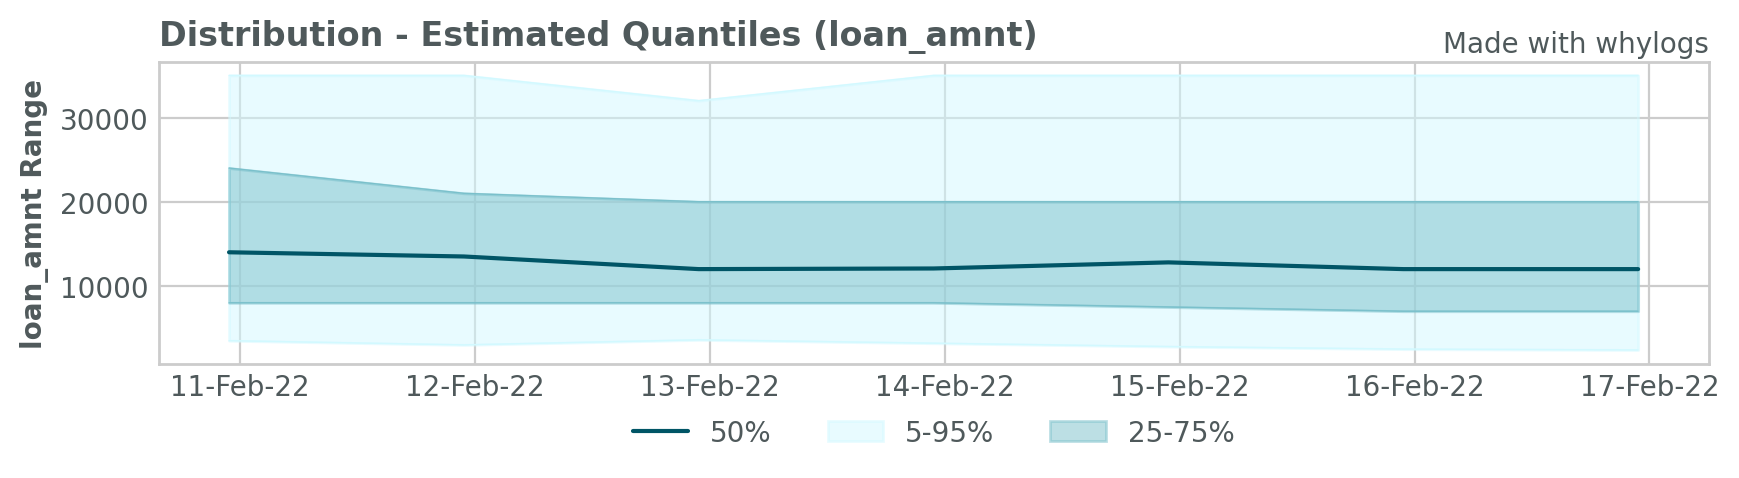

In [ ]:
from whylogs.viz import ProfileVisualizer

viz = ProfileVisualizer()
viz.set_profiles(profiles)
viz.plot_distribution("loan_amnt")

In [ ]:
# Ensure everything is pushed 
session.close()

### 📈 **ML Observability: Inspect profiles in the Observatory** 

WhyLabs' Observatory stores the follow statistics, from what is configured in `whylogs`

* Simple counters: boolean, null values, data types.
* Summary statistics: sum, min, max, median, variance.
* Unique value counter or cardinality: tracks an approximate unique value of your feature using HyperLogLog algorithm.
* Histograms for numerical features. whyLogs binary output can be queried to with dynamic binning based on the shape of your data.
* Top frequent items (default is 128). Note that this configuration affects the memory footprint, especially for text features.

Notice that these statistics are organized in batches. So if you run the above cells again, you'll see the statistics changed. 

* Now check the application to see if your **statistics** 
* Also, run the above cell again for the same model ID, do you see the statistics changes in WhyLabs? Especially the counters?

### 📝 **ML Observability: Run whylogs with your data & explore with Observatory features** 

To go further, visit our [documentation](https://docs.whylabs.ai/) for more detailed of everything that you can do to start monitoring your ML and data pipelines.

You can also join our [Community Slack Channel](http://join.slack.whylabs.ai/) for questions related to `whylogs`.
